In this notebook, I open a basicos_distritos_viajes file from whatever day, by using the open_gz function.

Then, I filter only Madrid districts in the dataset by using the function filter_district, and selecting those entries starting by 28079.

LIMITATION: I also do an extra filter on top of the Madrid district filter, just in case: I select those entries for which the 'actividad_origen' is 'casa', or 'actividad_destino' is 'casa', or both. The reason is that the residence of the users in the MITMA data is not by district, but by province. This could be a problem as I am trying to understand how people from different districts move, and it turns out I do not have individual district data on where the user's residence is, only province data. As a solution, by applying the previously mentioned filters, I can access the actual district of residence individually. The problem is that the mobility would be very limited to those trips either coming from or going home, hence reducing the richness of the dataset and the study overall.

Another solution would be to ignore the 'residence' variable and just focus on mobility around districts independently, maybe focusing on other variables like 'income'.

## TO DO:

1. Filter network based on purpose: people who go from home to work, from work to home, leisure, etc. Maybe filter as well by hours.
2. Calculate an 'amenity Moran's I' on top of the already calculated income moran's I, in segregation_indices.

In [66]:
import config as cfg
import os
import pandas as pd
from utils import get_overview, open_gz, filter_district
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

geometria_dir = cfg.GEOMETRIA_DATA
personas_dir = cfg.PERSONAS_DATA
viajes_dir = cfg.VIAJES_DATA
zonificacion_dir = cfg.ZONIFICACION_DATA

In [67]:
# FIXME: Read more about DtypeWarning and fix
all_viajes = pd.read_csv('viajes/all_viajes_week_0222.csv')

# NOTE: The residence of the users in the MITMA data is not by district, but by province. 
# This could be a problem as I am trying to understand how people from different districts move. 
# As a solution, I could filter to only use ‘origen’ == casa or ‘destino’==casa in the districts of Madrid. 
# This way, I could make sure that I am taking a look at those records of people who actually live in a specific district in Madrid.
# The problem is that the mobility would be very limited to those trips either coming from or going home.


# home_trips = madrid_1.loc[(madrid_1['actividad_origen'] == 'casa') | (madrid_1['actividad_destino'] == 'casa')]
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')]
# filtered_df, _ = train_test_split(home_trips, train_size=5000, stratify=home_trips['renta'], random_state=42) # selecting a balanced sample

In [68]:
# Step 1: Load the GeoJSON file
gdf = gpd.read_file(zonificacion_dir / 'distritos/madrid_gdf.geojson')  # Load your GeoJSON file into a GeoDataFrame
gdf = gdf.to_crs(epsg=3042)

In [70]:
# Step 2: Create a function to get the centroid of each district (or use other geometry)
# We'll use the 'ID' as the node identifier and the centroid of the polygon as the position
positions = {}
for idx, row in gdf.iterrows():
    district_id = row['ID']  # Assuming 'ID' is the district identifier matching the graph
    centroid = row['geometry'].centroid  # Get the centroid of the district's polygon
    positions[district_id] = (centroid.x, centroid.y)  # Store the centroid coordinates

positions = {int(key): value for key, value in positions.items()}

In [75]:
len(filtered_df)

781697

In [113]:
filtered_df.head()

,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km
0,20220207,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,hombre,20.700,14.144
1,20220207,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,mujer,25.476,15.796
2,20220207,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,hombre,102.263,69.730
3,20220207,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,mujer,86.178,63.775
4,20220207,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,45-65,hombre,43.469,31.687


In [123]:
G = nx.DiGraph()

# Iterate through the DataFrame rows to add edges and attributes
for _, row in filtered_df.iterrows():
    G.add_edge(row['origen'], row['destino'], weight=row['distancia'])

In [116]:
len(G.edges)

441

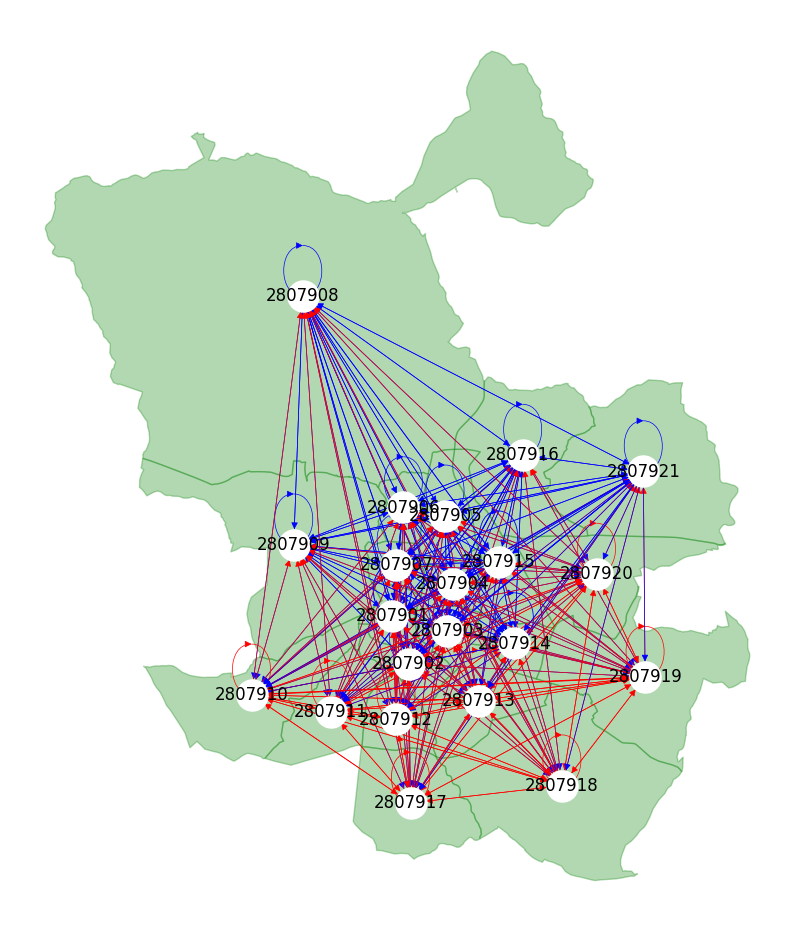

In [77]:
def define_graph_gender(df, weight_column):
    # filters to plot -- the edge color will change based on these filters
    attr1 = df[df['renta'] == '>15']
    attr2 = df[df['renta'] == '10-15']

    G = nx.DiGraph() 
    # add edges with attribute 1
    for idx, row in attr1.iterrows():
        G.add_edge(row['origen'], row['destino'], weight=row[weight_column], type='attr1')

    # add edges with attribute 2
    for idx, row in attr2.iterrows():
        G.add_edge(row['origen'], row['destino'], weight=row[weight_column], type='attr2')

    return G

def set_art(G):
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        # Set edge color based on the type
        if data['type'] == 'attr1':
            edge_colors.append('blue')  # attr1 edges will be blue
        else:
            edge_colors.append('red')   # attr2 edges will be red

        # Set edge width based on the number of trips (weight), avoid too small widths
        edge_widths.append(max(0.5, data['weight'] / 15))  # Scale down weight for visualization purposes

    return edge_colors, edge_widths

def plot_graph_and_background(G, pos, edge_colors, edge_widths, node_size, node_color, background, alpha):
    fig, ax = plt.subplots(figsize=(10, 15))

    # Plot the background if it is a GeoDataFrame
    if hasattr(background, 'plot'):
        background.plot(ax=ax, color='green', edgecolor='green', alpha=alpha)

    # Check that edge attributes match number of edges in G
    assert len(edge_colors) == len(edge_widths) == len(G.edges()), "Mismatch in lengths of edge attributes."

    # Draw the graph
    nx.draw(G, pos=pos, with_labels=True, edge_color=edge_colors, width=edge_widths, 
            node_size=node_size, node_color=node_color, ax=ax)

    plt.show()

# Example usage
G = define_graph_gender(filtered_df, 'viajes')
edge_colors, edge_widths = set_art(G)
plot_graph_and_background(G, positions, edge_colors, edge_widths, 500, 'white', gdf, 0.3)


In [122]:
nx.degree_centrality(G)

{2807901: 2.1,
 2807902: 2.1,
 2807903: 2.1,
 2807904: 2.1,
 2807905: 2.1,
 2807906: 2.1,
 2807907: 2.1,
 2807908: 2.1,
 2807909: 2.1,
 2807910: 2.1,
 2807911: 2.1,
 2807912: 2.1,
 2807913: 2.1,
 2807914: 2.1,
 2807915: 2.1,
 2807916: 2.1,
 2807917: 2.1,
 2807918: 2.1,
 2807919: 2.1,
 2807920: 2.1,
 2807921: 2.1}

In [121]:
nx.closeness_centrality(G)

{2807901: 1.0,
 2807902: 1.0,
 2807903: 1.0,
 2807904: 1.0,
 2807905: 1.0,
 2807906: 1.0,
 2807907: 1.0,
 2807908: 1.0,
 2807909: 1.0,
 2807910: 1.0,
 2807911: 1.0,
 2807912: 1.0,
 2807913: 1.0,
 2807914: 1.0,
 2807915: 1.0,
 2807916: 1.0,
 2807917: 1.0,
 2807918: 1.0,
 2807919: 1.0,
 2807920: 1.0,
 2807921: 1.0}

In [120]:
nx.betweenness_centrality(G)

{2807901: 0.0,
 2807902: 0.0,
 2807903: 0.0,
 2807904: 0.0,
 2807905: 0.0,
 2807906: 0.0,
 2807907: 0.0,
 2807908: 0.0,
 2807909: 0.0,
 2807910: 0.0,
 2807911: 0.0,
 2807912: 0.0,
 2807913: 0.0,
 2807914: 0.0,
 2807915: 0.0,
 2807916: 0.0,
 2807917: 0.0,
 2807918: 0.0,
 2807919: 0.0,
 2807920: 0.0,
 2807921: 0.0}

In [119]:
nx.average_shortest_path_length(G)

1.0

In [100]:
len(G.edges)

441

In [101]:
len(G.nodes)

21

In [118]:
nx.betweenness_centrality(G, weight='weight')

TypeError: unsupported operand type(s) for +: 'int' and 'str'

## Cytoscape

In [86]:
def nx_to_cytoscape_elements(G, positions):
    elements = []

    # Create nodes with positions
    for node in G.nodes():
        # Check if the node has a defined position
        if node in positions:
            x, y = positions[node]
            elements.append({
                'data': {'id': str(node), 'label': str(node)},
                'position': {'x': x, 'y': y}  # Add position to each node
            })
        else:
            elements.append({'data': {'id': str(node), 'label': str(node)}})

    # Create edges
    for source, target in G.edges():
        elements.append({'data': {'source': str(source), 'target': str(target)}})

    return elements

cy_elements = nx_to_cytoscape_elements(G, positions)

In [117]:
from dash import Dash, html
import dash_cytoscape as cyto

app = Dash(__name__)

app.layout = html.Div([
    html.P("Dash Cytoscape with Node Positions:"),
    cyto.Cytoscape(
        id='cytoscape',
        elements=cy_elements,  # Elements with positions
        layout={'name': 'preset'},  # Use 'preset' layout for custom positions
        style={'width': '600px','height': '600px', 'background-color': '#e0e0e0' },  # Set the size of the cytoscape container
        stylesheet=[
            {'selector': 'node',  # Style for nodes
             'style': {
                 'background-color': '#BFD7B5',
                 'label': 'data(label)',
                 'width': 100,  # Increase node width
                 'height': 100,  # Increase node height
                 'font-size': 100,  # Increase label font size
                 'text-halign': 'center',  # Center label horizontally
                 'text-valign': 'center'  # Center label vertically
             }},
            {'selector': 'edge',  # Style for edges
             'style': {'line-color': '#333333', 'width': 2}}
        ]
    )
])



app.run_server(debug=True)